# Create images

## SMILES

In [15]:
import os
from rdkit import Chem
from rdkit.Chem import Draw
from joblib import Parallel, delayed
from tqdm import tqdm

def smile_to_image(smile, path, img_size=(250, 250)):
    mol = Chem.MolFromSmiles(smile)
    draw = Draw.MolToFile(mol, path, size=img_size)

def convert_smi_to_img(df, out_dir, img_size=(250, 250)):
    smiles = list(df.smi)
    ids = list(df.index)
    
    img_paths = [os.path.join(out_dir, f'smi_images/{id}.png') for id in ids]

    os.makedirs(os.path.join(out_dir, 'smi_images'), exist_ok=True)
    Parallel(n_jobs=os.cpu_count())(delayed(smile_to_image)(s, p, img_size) for s, p in tqdm(zip(smiles, img_paths), ncols=80))

    return img_paths

# CycPeptMPDB


In [30]:
import pandas as pd


# train = True
train = False

if train:
    df_cycpdb_all = pd.read_csv('data/CycPeptMPDB/all.csv')
    df_cycpdb_all['smi_img'] = convert_smi_to_img(df_cycpdb_all, 'data/CycPeptMPDB')
    df_cycpdb_all['id'] = list(df_cycpdb_all.index)

    from sklearn.model_selection import train_test_split

    df_cycpdb_train, df_cycpdb_test = train_test_split(df_cycpdb_all, test_size=0.2, random_state=42)

    df_cycpdb_all.to_csv('data/CycPeptMPDB/img_all.csv', index=False)
    df_cycpdb_train.to_csv('data/CycPeptMPDB/img_train.csv', index=False)
    df_cycpdb_test.to_csv('data/CycPeptMPDB/img_test.csv', index=False)
else:
    df_cycpdb_all = pd.read_csv('data/CycPeptMPDB/img_all.csv')
    df_cycpdb_train = pd.read_csv('data/CycPeptMPDB/img_train.csv')
    df_cycpdb_test = pd.read_csv('data/CycPeptMPDB/img_test.csv')

print(len(df_cycpdb_all), len(df_cycpdb_train), len(df_cycpdb_test))


7451 5960 1491


# Visualization

In [22]:
import matplotlib.pyplot as plt
import cv2

data_dir = 'data/CycPeptMPDB/smi_images'

def show_image(img_paths, scores, nrow=3, ncol=4):
    plt.figure(figsize=(15,10))
    
    for i, (image_path, score) in enumerate(zip(img_paths, scores)):
        if i+1 > nrow*ncol:
            break
        plt.subplot(nrow, ncol, i+1)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(f"Score: {score}", fontsize=12)
        plt.axis("off")
    
    plt.show()

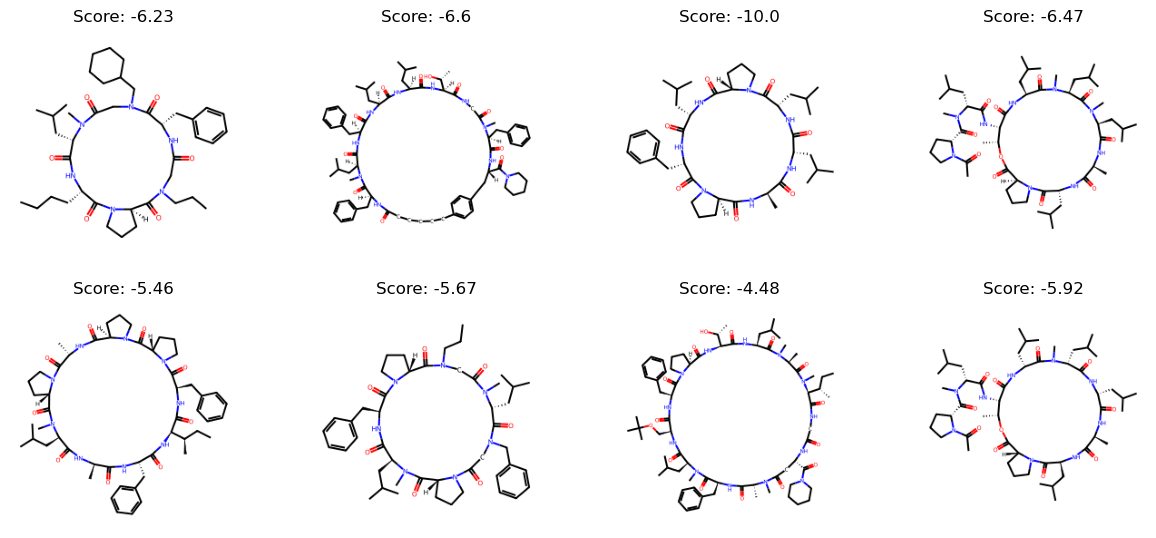

In [31]:
df_low = df_cycpdb_all[df_cycpdb_all.score < -6].sample(4)
df_high = df_cycpdb_all[df_cycpdb_all.score > -6].sample(4)
df_test = pd.concat([df_low, df_high])

show_image(df_test.smi_img, df_test.score)

# Augmentation

In [43]:
import cv2
import os
import pandas as pd
from joblib import Parallel, delayed
import os

class ImageAugmentations:

    def __init__(self, out_dir):
        self.out_dir = out_dir

    @staticmethod
    def rotating(img, num_rotations=6):
        (h, w) = img.shape[:2]
        center = (w / 2, h / 2)
        rotated_images = []
        for i in range(num_rotations):
            rotations = list(range(0, 180, num_rotations))
            M = cv2.getRotationMatrix2D(center, rotations[i], 1.0)
            rotated = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            rotated_images.append(rotated)
        return rotated_images

    @staticmethod
    def flipping(img):
        flipped_images = []
        originalImage = img
        flipVertical = cv2.flip(originalImage, 0)
        flipHorizontal = cv2.flip(originalImage, 1)
        flipBoth = cv2.flip(originalImage, -1)
        flipped_images.append(flipVertical)
        flipped_images.append(flipHorizontal)
        flipped_images.append(flipBoth)
        return flipped_images

    def aug_image(self, raw_img_path, save_dir):
        counter = 0
        fname = os.path.basename(raw_img_path)
        img = cv2.imread(raw_img_path)
        rot_imgs = self.rotating(img)
        aug_img_paths = []
        for im in rot_imgs:
            flip = self.flipping(im)
            for flipped in flip:
                aug_img_path = os.path.join(save_dir, f'{fname}_aug_{counter}.png')
                cv2.imwrite(aug_img_path, flipped)
                counter += 1
                aug_img_paths.append(aug_img_path)

        return raw_img_path, aug_img_paths

    def do_image_augmentations(self, paths, dir_name='aug_images'):
        save_dir = os.path.join(self.out_dir, dir_name)
        os.makedirs(save_dir, exist_ok=True)
        print(f"augmented images are saved to {save_dir}")
        aug_paths = Parallel(n_jobs=os.cpu_count())(delayed(self.aug_image)(p, save_dir) for p in tqdm(paths, ncols=80))
        return dict(aug_paths) # return dict of raw image path and augmented image paths

In [48]:
def augment_images(df, out_dir):
    augmentor = ImageAugmentations(out_dir)
    aug_paths_dict = augmentor.do_image_augmentations(df.smi_img)

    columns = df.columns

    augmented_images = []
    for index, row in df.iterrows():
        row_values = {col: row[col] for col in columns}
        for aug_path in aug_paths_dict[row['smi_img']]:
            row_values['smi_img'] = aug_path
            augmented_images.append(tuple(row_values.values()))

    df_augmented_images = pd.DataFrame(augmented_images, columns=columns)
    return df_augmented_images

# df_augmented_images = augment_images(df_cycpdb_train.sample(3), 'test/')
# show_image(df_augmented_images.smi_img, df_augmented_images.score, ncol=5, nrow=4)

In [47]:
# train = True
train = False
if train:
    df_cycpdb_train_aug = augment_images(df_cycpdb_train, 'data/CycPeptMPDB/smi_images/')
    df_cycpdb_train_aug.to_csv('data/CycPeptMPDB/img_train_aug.csv', index=False)
else:
    df_cycpdb_train_aug = pd.read_csv('data/CycPeptMPDB/img_train_aug.csv')

augmented images are saved to data/CycPeptMPDB/smi_images/aug_images


100%|██████████████████████████████████████| 5960/5960 [00:10<00:00, 545.74it/s]


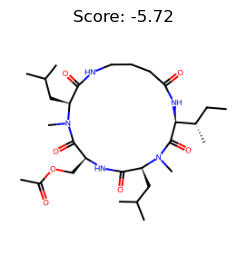

In [49]:
sample = df_cycpdb_train.sample(1)
sample_id = sample.id.values[0]
show_image(sample.smi_img, sample.score)

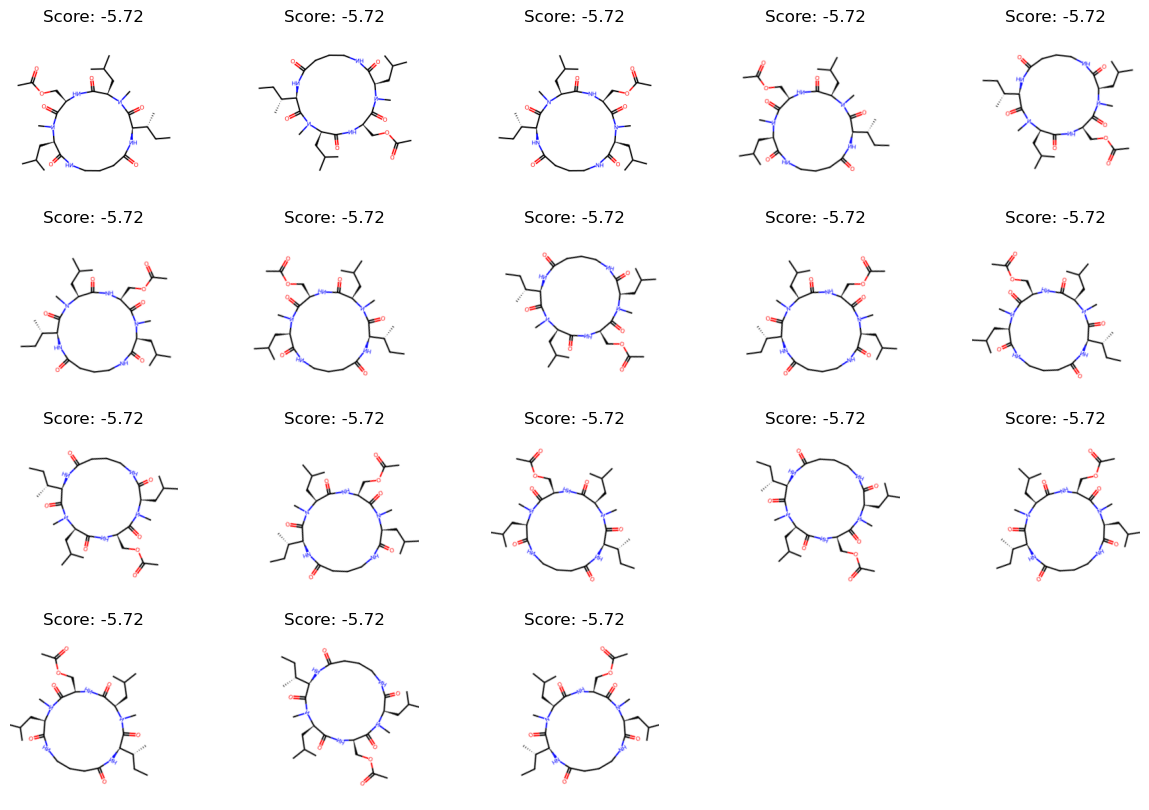

In [50]:
sample_augmented = df_cycpdb_train_aug[df_cycpdb_train_aug.id == sample_id]
show_image(sample_augmented.smi_img, sample_augmented.score, ncol=5, nrow=4)

# Test ResNet loading

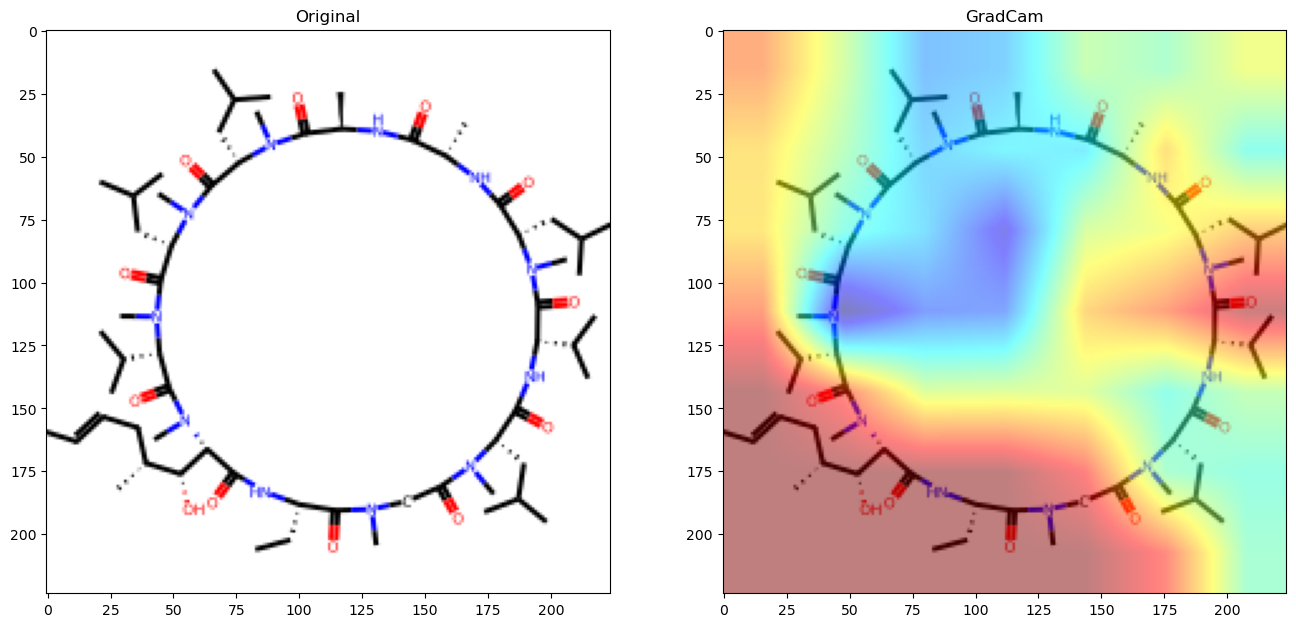

In [1]:
from model.resnet import init_model, load_model_from_ckpt
from utils.utils import count_params
from utils.gradcam_utils import run_gradcam

model = init_model("ResNet18", imageSize=224, num_classes=1)
model = load_model_from_ckpt("ResNet18", model, 'data/resnet_ckpt/ImageMol.pth.tar')

model = model.to('cuda')
model.eval()
count_params(model)  # 11 million parameters

run_gradcam("data/gradcam/cycpep_0.png", model)